### Imports and set path to local mavenn

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from numpy.random import default_rng

import warnings
warnings.filterwarnings('ignore')

import sys
path_to_mavenn_local = '/Users/tareen/Desktop/Research_Projects/2020_mavenn_github/mavenn_local'
sys.path.insert(0,path_to_mavenn_local)

import mavenn
from mavenn.src.utils import get_example_dataset
from mavenn.src.utils import ge_plots_for_mavenn_demo
from mavenn.src.utils import onehot_encode_array, _generate_nbr_features_from_sequences, _generate_all_pair_features_from_sequences
from mavenn.src.utils import _center_matrix

import tensorflow as tf
import tensorflow.keras.backend as K

# Path being used:
mavenn.__path__

['/Users/tareen/Desktop/Research_Projects/2020_mavenn_github/mavenn_local/mavenn']

In [2]:
X, y = get_example_dataset(name='GB1-DMS')

generating data: 0 out of 535918
generating data: 100000 out of 535918
generating data: 200000 out of 535918
generating data: 300000 out of 535918
generating data: 400000 out of 535918
generating data: 500000 out of 535918


In [3]:
# split data into test, we only need test data here, the loaded
# model will already contain the training data it was trained on
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state = 0)

## Load model from file

In [4]:
#GER = mavenn.load('model_files/cauchy_mpsa_model')
#GER = mavenn.load('model_files/gaussian_mpsa_model')
#GER = mavenn.load('model_files/skewT_mpsa_model')
GER = mavenn.load('model_files/gaussian_GB1_model')

In [5]:
GER.ge_noise_model_type

'Gaussian'

### Make predictions and compute latent phenotype values

In [6]:
# predictions
yhat = GER.x_to_yhat(x_test)

# evaluate phi for sequences 
phi = GER.x_to_phi(x_test)

# equalate g(phi) for continuous phi
phi_range = np.linspace(min(phi),max(phi),1000)
y_hat_GE = GER.phi_to_yhat(phi_range)

# noise model that is used to get eta parameters
qs = GER.yhat_to_yq(y_hat_GE,q=[0.16,0.84])

## Show plots

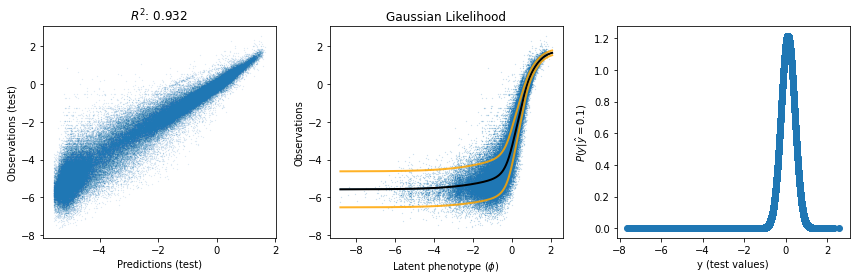

In [8]:
fig, ax = plt.subplots(1,3,figsize=(12,4))

Rsq = np.corrcoef(yhat.ravel(),y_test)[0][1]**2
ax[0].scatter(yhat,y_test,s=0.05,alpha=0.25)
ax[0].set_xlabel('Predictions (test)')
ax[0].set_ylabel('Observations (test)')
ax[0].set_title('$R^2$: '+str(Rsq)[0:5])

ax[1].plot(phi_range,GER.phi_to_yhat(phi_range))
ax[1].scatter(phi,y_test,s=0.05, alpha=0.4, label='Observations')
ax[1].plot(phi_range,GER.phi_to_yhat(phi_range),lw=2,label='$\hat{y}$',alpha=1.0,color='black')

for q_index in range(len(qs)):
    ax[1].plot(phi_range,qs[q_index].ravel(),color='orange',lw=2,alpha=0.85,label='$\hat{y} \pm \sigma(\hat{y})$')

ax[1].set_ylabel('Observations')
ax[1].set_xlabel('Latent phenotype ($\phi$)')
ax[1].set_title(GER.ge_noise_model_type+' Likelihood')

ax[2].scatter(y_test,GER.p_of_y_given_y_hat(y_test,0.1))
ax[2].set_ylabel('$P(y|\hat{y}=0.1)$')
ax[2].set_xlabel('y (test values)')

plt.tight_layout()
plt.show()

## Estimate predictive information

In [9]:
GER.I_predictive(x_test,y_test)

(2.1202346188304912, 0.003661890579069841)

In [10]:
# show model summary
GER.get_nn().summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Sequence_labels_input (InputLay (None, 1101)         0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1100)         0           Sequence_labels_input[0][0]      
__________________________________________________________________________________________________
phiPrime (Dense)                (None, 1)            1101        lambda[0][0]                     
__________________________________________________________________________________________________
fix_diffeomorphic_mode (fixDiff (None, 1)            0           phiPrime[0][0]                   
__________________________________________________________________________________________________
phi (Dense